# Arxiv Title Generation

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import joblib
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy

import collections
import copy
import random
import math
import time

import heapq

def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True
    
init_random_seed(1234)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Load Data

In [3]:
data = pd.read_csv('/kaggle/input/title-generation/train.csv')
print(data.shape)
data.head()

(135000, 2)


,abstract,title
0,we consider the problem of utility maximizatio...,on optimal investment with processes of long o...
1,in this paper we provide an explicit formula f...,boolean complexes for ferrers graphs
2,"kinesin-5, also known as eg5 in vertebrates is...",relative velocity of sliding of microtubules b...
3,we discuss the transition paths in a coupled b...,bifurcation of transition paths induced by cou...
4,two types of room temperature detectors of ter...,all-electric detectors of the polarization sta...


In [4]:
submission_data = pd.read_csv('/kaggle/input/title-generation/test.csv')
print(submission_data.shape)
submission_data.head()

(1000, 1)


,abstract
0,Most sequence transformation models use recurr...
1,The doc2vec approach was introduced as an exte...
2,LSTM models can vary greatly depending on sequ...
3,A joint learning process of alignment and tran...
4,Current unsupervised image-to-image translatio...


# Train-Test split

In [5]:
init_random_seed(1234)

val_ratio = 0.01
test_ratio = 0.01

val_idx = np.random.choice(a=len(data), size=int(len(data)*(val_ratio+test_ratio)), replace=False)

train_data = data.drop(val_idx).copy()
val_data = data.iloc[val_idx[:len(val_idx)//2]].copy()
test_data = data.iloc[val_idx[len(val_idx)//2:]].copy()

In [6]:
val_idx

array([114560, 104122,  12484, ...,  52198,   7428,  10138])

In [7]:
# check if there's no intersection among sets
print(set(train_data.index).intersection(set(val_data.index)))
print(set(train_data.index).intersection(set(test_data.index)))
print(set(val_data.index).intersection(set(test_data.index)))

set()
set()
set()


In [8]:
train_data.values[0][0], train_data.values[0][1]

('we consider the problem of utility maximization for investors with power utility functions. building on the earlier work larsen et al. (2016), we prove that the value of the problem is a frechet-differentiable function of the drift of the price process, provided that this drift lies in a suitable banach space.   we then study optimal investment problems with non-markovian driving processes. in such models there is no hope to get a formula for the achievable maximal utility. applying results of the first part of the paper we provide first order expansions for certain problems involving fractional brownian motion either in the drift or in the volatility. we also point out how asymptotic results can be derived for models with strong mean reversion.',
 'on optimal investment with processes of long or negative memory')

In [9]:
test_data.values[0]

array(['superparamagnetic iron oxide nanoparticles (spions) have recently been introduced as information carriers in a testbed for molecular communication (mc) in duct flow. here, a new receiver for this testbed is presented, based on the concept of a bridge circuit. the capability for a reliable transmission using the testbed and detection of the proposed receiver was evaluated by sending a text message and a 80 bit random sequence at a bit rate of 1/s, which resulted in a bit error rate of 0 %. furthermore, the sensitivity of the device was assessed by a dilution series, which gave a limit for the detectability of peaks between 0.1 to 0.5 mg/ml. compared to the commercial susceptometer that was previously used as receiver, the new detector provides an increased sampling rate of 100 samples/s and flexibility in the dimensions of the propagation channel. furthermore, it allows to implement both single-ended and differential signaling in spion-bases mc testbeds.',
       'novel receiver

In [10]:
spacy_en = spacy.load('en_core_web_sm')
def tokenize(text):
    """
    Tokenizes English text from a string into a list of strings (tokens)
    """
    return [tok.text for tok in spacy_en.tokenizer(text) if not tok.text.isspace()]

# Building vocabulary

In [11]:
def build_vocabulary(
    tokenized_texts,
    max_size=1000000,
    max_doc_freq=0.8,
    min_count=5,
    pad_word=None,
    unk_word=None,
    sos_word=None,
    eos_word=None
):
    word_counts = collections.defaultdict(int)
    doc_n = 0

    # посчитать количество документов, в которых употребляется каждое слово
    # а также общее количество документов
    for txt in tokenized_texts:
        doc_n += 1
        unique_text_tokens = set(txt)
        for token in unique_text_tokens:
            word_counts[token] += 1

    # убрать слишком редкие и слишком частые слова
    word_counts = {word: cnt for word, cnt in word_counts.items()
                   if cnt >= min_count and cnt / doc_n <= max_doc_freq}

    # отсортировать слова по убыванию частоты
    sorted_word_counts = sorted(word_counts.items(),
                                reverse=True,
                                key=lambda pair: pair[1])
    if unk_word is not None:
        sorted_word_counts = [(unk_word, 0)] + sorted_word_counts
    
    # добавим несуществующее слово с индексом 0 для удобства пакетной обработки
    if pad_word is not None:
        sorted_word_counts = [(pad_word, 0)] + sorted_word_counts
        
    if sos_word is not None:
        sorted_word_counts = [(sos_word, 0)] + sorted_word_counts
        
    if eos_word is not None:
        sorted_word_counts = [(eos_word, 0)] + sorted_word_counts

    # если у нас по прежнему слишком много слов, оставить только max_size самых частотных
    if len(word_counts) > max_size:
        sorted_word_counts = sorted_word_counts[:max_size]

    # нумеруем слова
    word2id = {word: i for i, (word, _) in enumerate(sorted_word_counts)}

    # нормируем частоты слов
    word2freq = np.array([cnt / doc_n for _, cnt in sorted_word_counts], dtype='float32')

    return word2id, word2freq

In [12]:
%%time
train_tokenized = [
    tokenize(sentence) for sentence in (train_data['abstract'] + ' ' + train_data['title'])
]

CPU times: user 51.6 s, sys: 1.16 s, total: 52.7 s
Wall time: 52.8 s


In [13]:
%%time
vocabulary, _ = build_vocabulary(
    train_tokenized,
    max_doc_freq=1,
    min_count=4,
    pad_word='<PAD>',
    unk_word='<UNK>',
    sos_word='<SOS>',
    eos_word='<EOS>'
)

print(len(vocabulary))
del train_tokenized, data

46644
CPU times: user 4.91 s, sys: 10.1 ms, total: 4.92 s
Wall time: 4.96 s


## Sorting texts by their length

In [14]:
train_data['len_abstract'] = train_data['abstract'].apply(len)
train_data['len_title'] = train_data['title'].apply(len)
train_data = train_data.sort_values(['len_abstract', 'len_title'], ascending=False)

val_data['len_abstract'] = val_data['abstract'].apply(len)
val_data['len_title'] = val_data['title'].apply(len)
val_data = val_data.sort_values(['len_abstract', 'len_title'], ascending=False)

test_data['len_abstract'] = test_data['abstract'].apply(len)
test_data['len_title'] = test_data['title'].apply(len)
test_data = test_data.sort_values(['len_abstract', 'len_title'], ascending=False)

In [15]:
class ArxivDataset(torch.utils.data.Dataset):
    def __init__(self,
                 src,
                 trg,
                 tokenizer,
                 vocabulary,
                 unk_word='<UNK>',
                 pad_word='<PAD>',
                 sos_word='<SOS>',
                 eos_word='<EOS>'
                ):
        self.tokenizer = tokenizer
        self.word2id = vocabulary
        self.unk_word = unk_word
        self.pad_word = pad_word
        self.sos_word = sos_word
        self.eos_word = eos_word
        
        # сразу токунизируем слова
        self.src = [self.tokenizer(sentence) for sentence in src]
        self.trg = [self.tokenizer(sentence) for sentence in trg]
        
    def __len__(self):
        return len(self.src)
    
    def __getitem__(self, i):
        # добавляем токены начала и конца предложения
        src_i = [self.sos_word] + self.src[i] + [self.eos_word]
        trg_i = [self.sos_word] + self.trg[i] + [self.eos_word]
        
        # переводим токены в их номера из словаря, при этом незнакомые токены переводим в неизвестный токен
        src_num = [self.word2id.get(word, self.word2id[self.unk_word]) for word in src_i]
        trg_num = [self.word2id.get(word, self.word2id[self.unk_word]) for word in trg_i]
        
        return src_num, trg_num

In [16]:
%%time
arx_dataset_train = ArxivDataset(
    train_data['abstract'].values,
    train_data['title'].values,
    tokenize,
    vocabulary
)
arx_dataset_val = ArxivDataset(
    val_data['abstract'].values,
    val_data['title'].values,
    tokenize,
    vocabulary
)
arx_dataset_test = ArxivDataset(
    test_data['abstract'].values,
    test_data['title'].values,
    tokenize,
    vocabulary
)

CPU times: user 36.6 s, sys: 53.4 ms, total: 36.6 s
Wall time: 36.7 s


In [17]:
vocabulary['<UNK>']

3

In [18]:
print(arx_dataset_train[50000])

([1, 8, 539, 30, 15, 51, 651, 6, 15226, 7, 68, 82, 10, 192, 7, 3710, 1279, 14, 281, 4, 5, 30, 14, 59, 11, 1355, 242, 2175, 12, 1303, 6482, 45, 25, 6391, 7, 1184, 2971, 23, 11662, 44, 2175, 12, 18802, 22, 9, 10, 32161, 44, 10, 740, 4, 2425, 6, 5, 240, 6, 6391, 19, 5, 192, 82, 6, 9975, 7917, 14, 280, 4, 15, 3452, 6482, 9, 2422, 14, 3141, 19, 5, 843, 47, 5, 886, 6, 24, 2306, 6324, 7, 8, 318, 6, 15226, 4, 740, 3801, 14, 1889, 9, 10, 118, 5, 61, 6, 5, 4414, 7941, 382, 4, 200, 159, 8473, 20, 280, 16, 35, 5, 3347, 6, 8, 40259, 7941, 446, 23, 297, 25, 8, 314, 7941, 6, 8, 103, 896, 6, 2484, 1504, 409, 5, 1017, 5100, 1610, 22, 19, 8, 282, 283, 12209, 4473, 446, 23, 66, 5, 4473, 14, 103, 25, 8, 519, 3754, 36263, 41, 5, 3550, 6, 5, 1610, 22, 9, 15, 5, 552, 9975, 3644, 10, 5, 3667, 4, 0], [1, 858, 58, 6, 5, 2800, 161, 8504, 105, 7, 63, 159, 5100, 340, 0])


In [19]:
class BatchSizeDataloader:
    def __init__(self, dataset, batch_size, pad_value, device, batch_first=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.dataset_len = len(dataset)
        self.pad_value = pad_value
        self.batch_first = batch_first
        
        # для создания итератора
        self.num = 0
        
    def __len__(self):
        return int(np.ceil(len(self.dataset) / self.batch_size))
    
    def __iter__(self):
        return self
    
    @staticmethod
    def ensure_length(txt: list, out_len: int, pad_value: int):
        """
        Функция для добавления фиктивных токенов в преложение вида [23, 43, 121]
        """
        if len(txt) < out_len:
            txt = list(txt) + [pad_value] * (out_len - len(txt))
        else:
            txt = txt[:out_len]
        return txt
    
    def __next__(self):
        if self.num >= self.__len__():
            # если итерирование закончено, то выставить счетчик снова в 0
            self.num = 0
            raise StopIteration
            
        src = []
        src_len = []
        trg = []
        trg_len = []
        for i in range(self.num*self.batch_size, (self.num+1)*self.batch_size):
            if i >= self.dataset_len:
                break
                
            src_i, trg_i = self.dataset[i]
            src.append(src_i)
            src_len.append(len(src_i))
            
            trg.append(trg_i)
            trg_len.append(len(trg_i))
            
        max_len_src = np.max(src_len)
        max_len_trg = np.max(trg_len)
        
        ensured_src = []
        ensured_trg = []
        for i in range(len(src)):
            src_i = src[i]
            trg_i = trg[i]
            
            ensured_src.append(self.ensure_length(src_i, max_len_src, self.pad_value))
            ensured_trg.append(self.ensure_length(trg_i, max_len_trg, self.pad_value))

        self.num += 1
        
        ensured_src = torch.tensor(ensured_src)
        src_len = torch.tensor(src_len)
        ensured_trg = torch.tensor(ensured_trg)
        trg_len = torch.tensor(trg_len)
        
        if not self.batch_first:
            ensured_src = ensured_src.permute(1, 0)
            ensured_trg = ensured_trg.permute(1, 0)
        
        return ensured_src.to(device), src_len, ensured_trg.to(device), trg_len

In [20]:
train_data_loader = BatchSizeDataloader(arx_dataset_train, batch_size=32, device=device, pad_value=vocabulary['<PAD>'])
val_data_loader = BatchSizeDataloader(arx_dataset_val, batch_size=32, device=device, pad_value=vocabulary['<PAD>'])
test_data_loader = BatchSizeDataloader(arx_dataset_test, batch_size=32, device=device, pad_value=vocabulary['<PAD>'])

In [21]:
j = 0
for src, src_len, trg, trg_len in train_data_loader:
    print(src)
    print(src_len)
    j += 1
    if j == 3:
        break

tensor([[   1,    1,    1,  ...,    1,    1,    1],
        [2347, 2347, 2347,  ...,   13, 2472, 2472],
        [ 249,  249,  249,  ...,   74,   12,   12],
        ...,
        [   9,    9,    9,  ...,    2,    2,    2],
        [ 329,  329,  329,  ...,    2,    2,    2],
        [   0,    0,    0,  ...,    2,    2,    2]], device='cuda:0')
tensor([699, 699, 699, 612, 666, 522, 522, 522, 546, 546, 539, 539, 515, 515,
        527, 527, 451, 461, 509, 432, 461, 396, 446, 446, 429, 429, 436, 388,
        390, 422, 423, 423])
tensor([[    1,     1,     1,  ...,     1,     1,     1],
        [    5,     5,     8,  ...,  2176,  2176,     5],
        [ 1267,  1267, 38654,  ...,   315,   315,   951],
        ...,
        [    2,     2,     2,  ...,     2,     2,     2],
        [    2,     2,     2,  ...,     2,     2,     2],
        [    2,     2,     2,  ...,     2,     2,     2]], device='cuda:0')
tensor([392, 392, 375, 375, 403, 376, 376, 364, 418, 418, 368, 381, 381, 367,
        367, 35

In [22]:
src.shape

torch.Size([391, 32])

# Modeling

In [23]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional = True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src = [src sent len, batch size]
        #src_len = [src sent len]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src sent len, batch size, emb dim]
                
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, src_len, enforce_sorted=False)
                
        packed_outputs, hidden = self.rnn(packed_embedded)
                                 
        #packed_outputs is a packed sequence containing all hidden states
        #hidden is now from the final non-padded element in the batch
            
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs) 
            
        #outputs is now a non-packed sequence, all hidden states obtained
        #  when the input is a pad token are all zeros
            
        #outputs = [sent len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards 
        #  encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)))
        
        #outputs = [sent len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

In [24]:
class Attention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Parameter(torch.rand(dec_hid_dim))
        
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]
        #mask = [batch size, src sent len]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat encoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src sent len, dec hid dim]
        #encoder_outputs = [batch size, src sent len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        
        #energy = [batch size, src sent len, dec hid dim]
                
        energy = energy.permute(0, 2, 1)
        
        #energy = [batch size, dec hid dim, src sent len]
        
        #v = [dec hid dim]
        
        v = self.v.repeat(batch_size, 1).unsqueeze(1)
        
        #v = [batch size, 1, dec hid dim]
            
        attention = torch.bmm(v, energy).squeeze(1)
        
        #attention = [batch size, src sent len]
        
        attention = attention.masked_fill(mask == 0, -1e10)
        
        return F.softmax(attention, dim = 1)

In [25]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.output_dim = output_dim
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]
        #mask = [batch size, src sent len]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
                
        #a = [batch size, src sent len]
        
        a = a.unsqueeze(1)
        
        #a = [batch size, 1, src sent len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src sent len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [sent len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #sent len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        output = self.out(torch.cat((output, weighted, embedded), dim = 1))
        
        #output = [bsz, output dim]
        
        return output, hidden.squeeze(0), a.squeeze(1)

In [26]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, pad_idx, sos_idx, eos_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.pad_idx = pad_idx
        self.sos_idx = sos_idx
        self.eos_idx = eos_idx
        self.device = device
        
    def create_mask(self, src):
        mask = (src != self.pad_idx).permute(1, 0)
        return mask
        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src sent len, batch size]
        #src_len = [batch size]
        #trg = [trg sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        if trg is None:
            assert teacher_forcing_ratio == 0, "Must be zero during inference"
            inference = True
            trg = torch.zeros((100, src.shape[1])).long().fill_(self.sos_idx).to(src.device)
        else:
            inference = False
            
        batch_size = src.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        #tensor to store attention
        attentions = torch.zeros(max_len, batch_size, src.shape[0]).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src, src_len)
                
        #first input to the decoder is the <sos> tokens
        input = trg[0,:]
        
        mask = self.create_mask(src)
                
        #mask = [batch size, src sent len]
                
        for t in range(1, max_len):
            
            #insert input token embedding, previous hidden state, all encoder hidden states 
            # and mask
            #receive output tensor (predictions), new hidden state and attention tensor
            output, hidden, attention = self.decoder(input, hidden, encoder_outputs, mask)
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #place attentions in a tensor holding attention value for each input token
            attentions[t] = attention
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input = trg[t] if teacher_force else top1
            
            #if doing inference and next token/prediction is an eos token then stop
            if inference and input.item() == self.eos_idx:
                return outputs[:t], attentions[:t]
            
        return outputs, attentions

In [27]:
INPUT_DIM = len(vocabulary)
OUTPUT_DIM = len(vocabulary)
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
ENC_HID_DIM = 64
DEC_HID_DIM = 64
ENC_DROPOUT = 0.8
DEC_DROPOUT = 0.8
PAD_IDX = vocabulary['<PAD>']
SOS_IDX = vocabulary['<SOS>']
EOS_IDX = vocabulary['<EOS>']

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, PAD_IDX, SOS_IDX, EOS_IDX, device).to(device)

In [28]:
def init_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)
            
model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(46644, 128)
    (rnn): GRU(128, 64, bidirectional=True)
    (fc): Linear(in_features=128, out_features=64, bias=True)
    (dropout): Dropout(p=0.8, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attn): Linear(in_features=192, out_features=64, bias=True)
    )
    (embedding): Embedding(46644, 128)
    (rnn): GRU(256, 64)
    (out): Linear(in_features=320, out_features=46644, bias=True)
    (dropout): Dropout(p=0.8, inplace=False)
  )
)

In [29]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 27,070,580 trainable parameters


In [30]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

In [31]:
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output


def train(model, iterator, optimizer, criterion, clip, train_history=None, valid_history=None):
    
    model.train()
    
    epoch_loss = 0
    history = []
    for i, batch in enumerate(iterator):
        
        src, src_len, trg, trg_len = batch
        
        optimizer.zero_grad()
        
        output, attetion = model(src, src_len, trg)
        
        #trg = [trg sent len, batch size]
        #output = [trg sent len, batch size, output dim]

        output = output[1:].view(-1, output.shape[-1])
        trg = trg[1:].reshape(-1)
        
        #trg = [(trg sent len - 1) * batch size]
        #output = [(trg sent len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
        history.append(loss.cpu().data.numpy())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()
            
            plt.show()
        
    return epoch_loss / len(iterator)

In [32]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src, src_len, trg, trg_len = batch

            output, attention = model(src, src_len, trg, 0) #turn off teacher forcing

            #trg = [trg sent len, batch size]
            #output = [trg sent len, batch size, output dim]

            output = output[1:].view(-1, output.shape[-1])
            trg = trg[1:].reshape(-1)

            #trg = [(trg sent len - 1) * batch size]
            #output = [(trg sent len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [33]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [34]:
MODEL_NAME = '/kaggle/working/baseline3.pt'

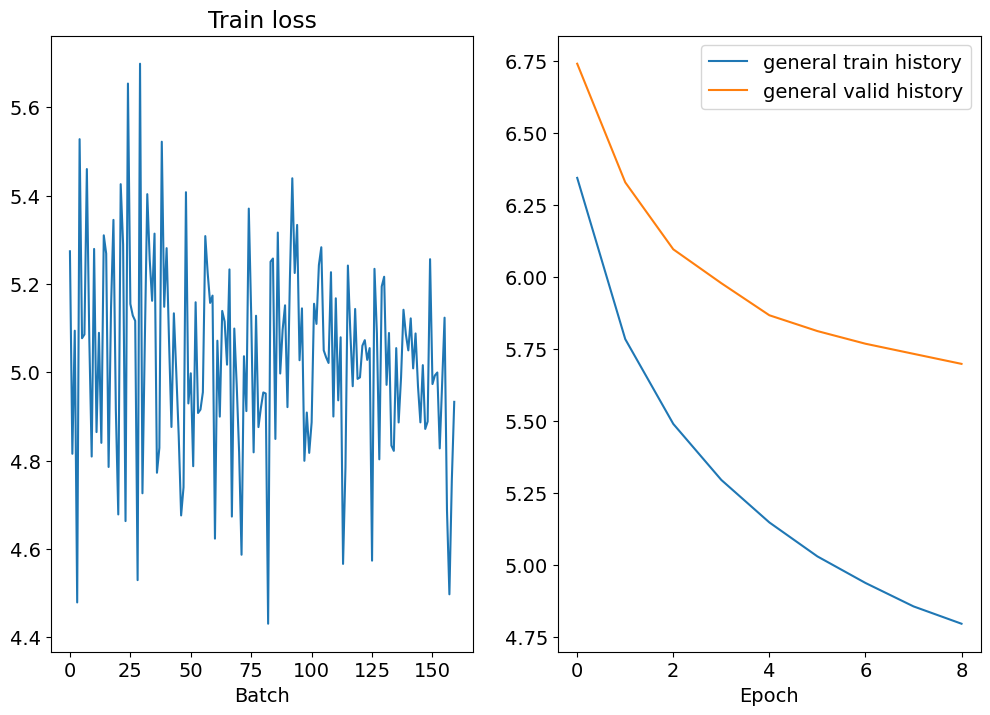

KeyboardInterrupt: 

In [35]:
N_EPOCHS = 15
CLIP = 1

train_data_loader = BatchSizeDataloader(arx_dataset_train, batch_size=32, device=device, pad_value=vocabulary['<PAD>'])
val_data_loader = BatchSizeDataloader(arx_dataset_val, batch_size=32, device=device, pad_value=vocabulary['<PAD>'])
test_data_loader = BatchSizeDataloader(arx_dataset_test, batch_size=32, device=device, pad_value=vocabulary['<PAD>'])

train_history = []
valid_history = []

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_data_loader, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate(model, val_data_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_NAME)
        
        
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [36]:
# for cpu usage
# model.load_state_dict(torch.load(MODEL_NAME, map_location=torch.device('cpu')))


test_loss = evaluate(model, test_data_loader, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 5.709 | Test PPL: 301.428 |


# Generating

In [37]:
id2word = {value: key for key, value in vocabulary.items()}
id2word[0]

'<EOS>'

In [68]:
def translate_sentence_naive(model, tokenized_sentence, word2id, id2word):
    model.eval()
    numericalized = [word2id.get(word, word2id['<UNK>']) for word in tokenized_sentence]
    sentence_length = torch.LongTensor([len(numericalized)])
    tensor = torch.LongTensor(numericalized).unsqueeze(1).to(device) 
    translation_tensor_logits, attention = model(tensor, sentence_length, None, 0)
#     translation_tensor = [np.random.choice(len(word2id), size=1, p=F.softmax(translation_tensor_logits[i]).ravel().cpu().detach().numpy())[0]
#                          for i in range(len(translation_tensor_logits))]
#     translation = [id2word.get(word, id2word[word2id['<UNK>']]) for word in translation_tensor]
    translation_tensor = torch.argmax(translation_tensor_logits.squeeze(1), 1)
    translation = [id2word.get(word, id2word[word2id['<UNK>']]) for word in translation_tensor.cpu().detach().tolist()]
    translation, attention = translation[1:], attention[1:]
    return translation, attention

def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(30,50))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy().T
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=12)
    ax.set_yticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'])
    ax.set_xticklabels(['']+translation, rotation=80)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [69]:
example_idx = 1060

src, trg = arx_dataset_train[example_idx]

print(f'src = {src}')
print(f'trg = {trg}')

src = [1, 3755, 47, 1622, 9, 1622, 7, 1565, 2948, 4983, 23, 3, 22, 7, 302, 3, 1010, 53, 6, 5, 162, 6299, 6, 1088, 6, 5375, 12, 2788, 4717, 23, 3, 22, 4, 8, 921, 722, 7, 2425, 6, 3755, 10, 9643, 234, 406, 107, 15, 3, 4279, 7, 15, 5, 333, 7, 1413, 6, 340, 428, 4, 13, 59, 7410, 2184, 11, 905, 646, 12, 238, 407, 23, 163, 3755, 163, 22, 47, 1015, 10, 5, 33995, 1058, 6, 8, 3488, 5375, 4, 1848, 794, 321, 606, 17, 8, 374, 705, 6, 206, 4292, 7897, 7, 8, 662, 705, 6, 1562, 4579, 4, 5, 52, 1676, 8449, 3, 7, 5719, 1622, 7, 18450, 15, 885, 2572, 7, 885, 11678, 4, 3, 3755, 321, 2076, 4, 5, 71, 7, 2127, 6, 3755, 3712, 47, 3, 9, 3, 7, 11678, 9, 7, 1848, 534, 1193, 5, 1238, 513, 47, 3, 7, 1622, 321, 1509, 15, 99, 51, 895, 4, 1848, 513, 321, 2385, 288, 28, 53, 2194, 11, 5, 1003, 4, 7500, 418, 6, 5, 3755, 3940, 47, 1000, 6, 3, 7, 1489, 3, 3998, 15, 7498, 418, 6, 85, 5, 3755, 199, 41, 395, 53, 2348, 9, 1840, 8, 318, 6, 1015, 1410, 449, 1232, 2574, 25, 1801, 12, 24997, 4, 7410, 2184, 1010, 8, 185, 605, 15,

In [70]:
translation, attention = translate_sentence_naive(model, [id2word[word] for word in src], vocabulary, id2word)

print(f'predicted trg = {translation}')
print(f'true trg = {[id2word[word] for word in trg]}')

predicted trg = ['a', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'of', 'infectious', 'disease', 'of', 'infectious', 'diseases']
true trg = ['<SOS>', 'estimating', 'potential', 'infection', 'transmission', 'routes', 'in', 'hospital', 'wards', 'using', 'wearable', 'proximity', 'sensors', '<EOS>']


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator


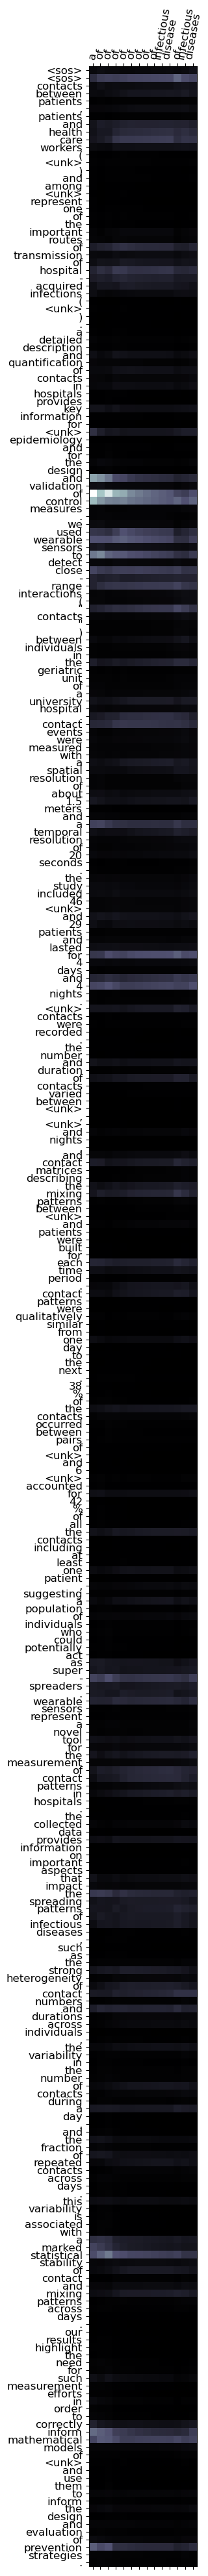

In [71]:
display_attention([id2word[word] for word in src], translation, attention)

In [72]:
for example_idx in range(100):
    src, trg = arx_dataset_test[example_idx]
    src = [id2word[word] for word in src]
    trg = [id2word[word] for word in trg]
    translation, attention = translate_sentence_naive(model, src, vocabulary, id2word)

    print('Оригинальный заголовок: ', ' '.join(trg))
    print('Предсказанный заголовок: ', ' '.join(translation))
    print('-----------------------------------')

Оригинальный заголовок:  <SOS> least squares after model selection in high - dimensional sparse models <EOS>
Предсказанный заголовок:  selection selection selection selection selection selection selection selection selection selection selection selection selection selection selection selection selection selection selection
-----------------------------------
Оригинальный заголовок:  <SOS> multiple tests of association with biological annotation metadata <EOS>
Предсказанный заголовок:  testing genome - wide association studies
-----------------------------------
Оригинальный заголовок:  <SOS> mcmc methods for functions : modifying old algorithms to make them faster <EOS>
Предсказанный заголовок:  gaussian mcmc sampling for gaussian processes
-----------------------------------
Оригинальный заголовок:  <SOS> evaluation of linear classifiers on articles containing pharmacokinetic evidence of drug - drug interactions <EOS>
Предсказанный заголовок:  drug drug drug drug drug drug drug drug i

In [73]:
class BeamGenerator:
    def __init__(self, model, tokenizer, device='cuda', eos_token_id=3):
        self.model = model
        self.tokenizer = tokenizer
        self.device = torch.device(device)
        self.model.to(self.device)
        self.eos_token_id = eos_token_id

    def __call__(self, seed_text, max_steps_n=40, return_hypotheses_n=5, beamsize=5):
        seed_tokens = self.tokenizer.encode([seed_text])[0]
        initial_length = len(seed_tokens)

        partial_hypotheses = [(0, seed_tokens)]
        final_hypotheses = []

        while len(partial_hypotheses) > 0:
            cur_partial_score, cur_partial_hypothesis = heapq.heappop(partial_hypotheses)

            in_batch = torch.tensor(cur_partial_hypothesis).unsqueeze(0).to(self.device)
            next_tokens_logits = self.model(in_batch)[0, -1]
            next_tokens_logproba = F.log_softmax(next_tokens_logits)
            topk_continuations = next_tokens_logproba.topk(beamsize)

            for token_score, token_idx in zip(topk_continuations.values, topk_continuations.indices):
                token_score = float(token_score)
                token_idx = int(token_idx)

                old_denorm_score = cur_partial_score * np.sqrt(len(cur_partial_hypothesis))
                new_score = (old_denorm_score - token_score) / np.sqrt(len(cur_partial_hypothesis) + 1)

                new_hypothesis = cur_partial_hypothesis + [token_idx]
                new_item = (new_score, new_hypothesis)

                if token_idx == self.eos_token_id or len(new_hypothesis) - initial_length >= max_steps_n:
                    final_hypotheses.append(new_item)
                else:
                    heapq.heappush(partial_hypotheses, new_item)

            if len(partial_hypotheses) > beamsize:
                partial_hypotheses = heapq.nsmallest(beamsize, partial_hypotheses)
                heapq.heapify(partial_hypotheses)

        final_scores, final_token_lists = zip(*final_hypotheses)
        final_texts = self.tokenizer.decode(list(final_token_lists))

        result = list(zip(final_scores, final_texts))
        result.sort()
        result = result[:return_hypotheses_n]

        return result

# Считаем метрики

In [74]:
import nltk

n_gram_weights = [0.3334, 0.3333, 0.3333]
test_len = len(arx_dataset_test)

original_texts = []
generated_texts = []
macro_bleu = 0

for example_idx in range(test_len):
    src, trg = arx_dataset_test[example_idx]
    src = [id2word[word] for word in src]
    trg = [id2word[word] for word in trg]
    translation, _ = translate_sentence_naive(model, src, vocabulary, id2word)

    original_texts.append(trg)
    generated_texts.append(translation)

    bleu_score = nltk.translate.bleu_score.sentence_bleu(
        [trg],
        translation,
        weights = n_gram_weights
    )    
    macro_bleu += bleu_score

macro_bleu /= test_len

/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/opt/conda/lib/python3.7/site-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [76]:
# averaging sentence-level BLEU (i.e. macro-average precision)
print('Macro-average BLEU (LSTM): {0:.5f}'.format(macro_bleu))

Macro-average BLEU (LSTM): 0.25968


# Submission

In [77]:
submission_data = pd.read_csv('/kaggle/input/title-generation/test.csv')
abstracts = submission_data['abstract'].values

In [78]:
%%time
tokenized_abstracts = [tokenize(sentence) for sentence in abstracts]

CPU times: user 256 ms, sys: 7.25 ms, total: 263 ms
Wall time: 262 ms


In [79]:
titles = []
for abstract in tokenized_abstracts:
    title, _ = translate_sentence_naive(model, abstract, vocabulary, id2word)
    titles.append(' '.join(title).replace('<UNK>', ''))

In [80]:
submission_df = pd.DataFrame({'abstract': abstracts, 'title': titles})
submission_df.to_csv('predicted_titles.csv', index=False)

In [81]:
import string
from nltk.util import ngrams
import numpy as np
import pandas as pd
import pickle


def generate_csv(input_file='predicted_titles.csv',
                 output_file='submission.csv',
                 voc_file='/kaggle/input/title-generation/vocs.pkl'):
    '''
    Generates file in format required for submitting result to Kaggle
    
    Parameters:
        input_file (str) : path to csv file with your predicted titles.
                           Should have two fields: abstract and title
        output_file (str) : path to output submission file
        voc_file (str) : path to voc.pkl file
    '''
    data = pd.read_csv(input_file).fillna(' ')
    with open(voc_file, 'rb') as voc_file:
        vocs = pickle.load(voc_file)

    with open(output_file, 'w') as res_file:
        res_file.write('Id,Predict\n')
        
    output_idx = 0
    for row_idx, row in data.iterrows():
        trg = row['title']
        trg = trg.translate(str.maketrans('', '', string.punctuation)).lower().split()
        if len(trg) > 1:
            trg.extend(['_'.join(ngram) for ngram in list(ngrams(trg, 2)) + list(ngrams(trg, 3))])
        
        VOCAB_stoi = vocs[row_idx]
        trg_intersection = set(VOCAB_stoi.keys()).intersection(set(trg))
        trg_vec = np.zeros(len(VOCAB_stoi))    

        for word in trg_intersection:
            trg_vec[VOCAB_stoi[word]] = 1

        with open(output_file, 'a') as res_file:
            for is_word in trg_vec:
                res_file.write('{0},{1}\n'.format(output_idx, int(is_word)))
                output_idx += 1


generate_csv()

In [82]:
pd.read_csv('/kaggle/working/submission.csv')

,Id,Predict
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
343437,343437,0
343438,343438,0
343439,343439,0
343440,343440,0


In [83]:
pd.read_csv('/kaggle/working/predicted_titles.csv')

,abstract,title
0,Most sequence transformation models use recurr...,recurrent neural networks recurrent neural net...
1,The doc2vec approach was introduced as an exte...,: a topic language models
2,LSTM models can vary greatly depending on sequ...,a - - topic models for topic models
3,A joint learning process of alignment and tran...,: a sequence sequence sequence sequence
4,Current unsupervised image-to-image translatio...,image image reconstruction using image - image...
...,...,...
995,subsystem codes are the most versatile class o...,secure codes codes codes codes
996,we study dirac-harmonic maps from degenerating...,the - of the - - - - -
997,in this note we study kloosterman sums twisted...,polynomial sums of sums of prime prime
998,we obtain the rate of growth of long strange s...,the the of of of of of ruin of the subcritical...
